In [61]:
from __future__ import print_function
import logging
import numpy as np
import sys
import csv

from optparse import OptionParser
from configparser import ConfigParser
import time
from pymongo import MongoClient
from twython import Twython, TwythonRateLimitError
from dateutil import parser
import datetime as dt
from datetime import datetime

from twitter import Twitter, OAuth
from pandas import DataFrame, read_csv
import pandas as pd

config = ConfigParser()
config.read('twitter.cfg')
# for py27 change config to get_config
APP_KEY       = config.get('credentials','app_key')
APP_SECRET    = config['credentials']['app_secret']
twitter       = Twython(APP_KEY, APP_SECRET, oauth_version=2)
ACCESS_TOKEN  = twitter.obtain_access_token()
twitter       = Twython(APP_KEY, access_token=ACCESS_TOKEN)

logging.basicConfig(filename='TwitterSNA.log',level=logging.DEBUG)
logging.info('TEST 14-10-2017')
logging.warning('GO!')

screen_name  = 'retromaquinitas'     # The main twitter account
n_days       = 30          # Only tweets more recent than n_days are kept
n_friends  = 500

def wait_for_awhile():
    reset = int(twitter.get_lastfunction_header('x-rate-limit-reset'))
    wait = max(reset - time.time(), 0) + 10
    print("Rate limit exceeded waiting: %sm %0.0fs"%
            (int(int( wait)/60),wait % 60 ))
    time.sleep(wait)
    
def friends_status(screen_name):
    friends = db.friends_calleja.find_one({"screen_name": screen_name})
    print("We have %s friends IDs for %s" %
                (len(friends['ids']), screen_name))

C:\ProgramData\Anaconda\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: You passed a bytestring as `filenames`. This will not work on Python 3. Use `cp.read_file()` or switch to using Unicode strings across the board.


In [72]:
result = twitter.search(q='#VolandoVoyRomanico', count = 100)
result


{u'search_metadata': {u'completed_in': 0.092,
  u'count': 100,
  u'max_id': 921363534302326784L,
  u'max_id_str': u'921363534302326784',
  u'next_results': u'?max_id=920210268772294655&q=%23VolandoVoyRomanico&count=100&include_entities=1',
  u'query': u'%23VolandoVoyRomanico',
  u'refresh_url': u'?since_id=921363534302326784&q=%23VolandoVoyRomanico&include_entities=1',
  u'since_id': 0,
  u'since_id_str': u'0'},
 u'statuses': [{u'contributors': None,
   u'coordinates': None,
   u'created_at': u'Fri Oct 20 13:12:39 +0000 2017',
   u'entities': {u'hashtags': [{u'indices': [62, 81],
      u'text': u'VolandoVoyRom\xe1nico'}],
    u'symbols': [],
    u'urls': [],
    u'user_mentions': [{u'id': 491257841,
      u'id_str': u'491257841',
      u'indices': [3, 19],
      u'name': u'FSMLRPH',
      u'screen_name': u'FundacionSMLRPH'},
     {u'id': 130467621,
      u'id_str': u'130467621',
      u'indices': [29, 42],
      u'name': u'Jes\xfas Calleja',
      u'screen_name': u'JesusCalleja'}]},
  

In [17]:
print (result['statuses'][0]['user']['screen_name'])
for mention in result['statuses'][0]['entities']['user_mentions']:
    print(mention['screen_name'])
if 'retweeted_status' in result['statuses'][0]:
    print (result['statuses'][0]['retweeted_status']['user']['screen_name'])


Juan17pa
JesusCalleja
CyLesVida
JesusCalleja


In [21]:
tweet_query_size = 1000 # Buscamos alrededor de 1000
print("Retrieving %s tweets" % tweet_query_size)


next_max_id     = -1
tweet_list_ids = []
first_time = True

with open('tweet_list_calleja.csv', 'wb') as csvfile:
    writer = csv.writer(csvfile, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    
    result = twitter.search(q='#VolandoVoyRomanico', result_type = 'popular') #añadimos como mucho los 15 más populares
    
    for tw in result['statuses']:
                print ('POPULAR ' + str(tw['id']))
                if tw['id'] not in tweet_list_ids:
                    tweet_list_ids.append(tw['id'])
                    retweet = False
                    retweet_user = 'NA'
                    mention = 'NA'
                    if 'retweeted_status' in tw:
                        retweet = True
                        retweet_user = tw['retweeted_status']['user']['screen_name']
                    if (len(tw['entities']['user_mentions']) == 0):
                        writer.writerow([tw['user']['screen_name'], tw['user']['id'], tw['user']['followers_count'], 
                                         tw['id'], tw['in_reply_to_screen_name'], retweet, retweet_user, 'NA',
                                         tw['text'].encode('utf-8').strip(), tw['created_at']])
                    else:
                        for mention in tw['entities']['user_mentions']:
                            writer.writerow([tw['user']['screen_name'], tw['user']['id'], tw['user']['followers_count'], 
                                         tw['id'], tw['in_reply_to_screen_name'], retweet, retweet_user, mention['screen_name'],
                                         tw['text'].encode('utf-8').strip(), tw['created_at']])
    
    while (len(tweet_list_ids) < tweet_query_size):
        try:
            print("Tweets %s to %s: cursor: %s" %
                    (len(tweet_list_ids), len(tweet_list_ids) + 100, next_max_id))

            result = twitter.search(q='#VolandoVoyRomanico', count = 100, max_id = next_max_id)
            

            for tw in result['statuses']:
                if (first_time == True):
                    first_time = False
                    next_max_id = tw['id']
                #print (tw['id'])
                if tw['id'] not in tweet_list_ids:
                    tweet_list_ids.append(tw['id'])
                    next_max_id = min(tw['id'], next_max_id) #update oldest tweet
                    retweet = False
                    retweet_user = 'NA'
                    mention = 'NA'
                    if 'retweeted_status' in tw:
                        retweet = True
                        retweet_user = tw['retweeted_status']['user']['screen_name']
                    if (len(tw['entities']['user_mentions']) == 0):
                        writer.writerow([tw['user']['screen_name'], tw['user']['id'], tw['user']['followers_count'], 
                                         tw['id'], tw['in_reply_to_screen_name'], retweet, retweet_user, 'NA',
                                         tw['text'].encode('utf-8').strip(), tw['created_at']])
                    else:
                        for mention in tw['entities']['user_mentions']:
                            writer.writerow([tw['user']['screen_name'], tw['user']['id'], tw['user']['followers_count'], 
                                         tw['id'], tw['in_reply_to_screen_name'], retweet, retweet_user, mention['screen_name'],
                                         tw['text'].encode('utf-8').strip(), tw['created_at']])

            print("Retrieved %s Tweet IDs from twitter" % len(tweet_list_ids))
            # store what we've got so far
            # insert follower_ids in the followers collection               

        except TwythonRateLimitError as e:
            # Wait if we hit the Rate limit
            wait_for_awhile()
        except:
            print(" FAILED: Unexpected error:", sys.exc_info()[0])
            pass

Retrieving 1000 tweets
POPULAR 919669430614978562
POPULAR 919675647458467840
POPULAR 919675012373770240
POPULAR 919664665617199104
POPULAR 919655081422843905
Tweets 5 to 105: cursor: -1
Retrieved 105 Tweet IDs from twitter
Tweets 105 to 205: cursor: 919684875728375808
Retrieved 204 Tweet IDs from twitter
Tweets 204 to 304: cursor: 919681386264645632
Retrieved 303 Tweet IDs from twitter
Tweets 303 to 403: cursor: 919678415229374465
Retrieved 402 Tweet IDs from twitter
Tweets 402 to 502: cursor: 919676050447183874
Retrieved 499 Tweet IDs from twitter
Tweets 499 to 599: cursor: 919674118131322880
Retrieved 598 Tweet IDs from twitter
Tweets 598 to 698: cursor: 919672501642330114
Retrieved 697 Tweet IDs from twitter
Tweets 697 to 797: cursor: 919671209750605825
Retrieved 796 Tweet IDs from twitter
Tweets 796 to 896: cursor: 919670235237625856
Retrieved 894 Tweet IDs from twitter
Tweets 894 to 994: cursor: 919669355117506560
Retrieved 993 Tweet IDs from twitter
Tweets 993 to 1093: cursor: 91

In [22]:
df = pd.read_csv('tweet_list_calleja.csv', header=None)
df.head(20)

,0,1,2,3,4,5,6,7,8,9
0,cuatro,106397073,1103046,919669430614978562,NaN,False,NaN,JesusCalleja,Conoce todas las paradas de la ruta ciclista '...,Sun Oct 15 21:00:53 +0000 2017
1,telecincoes,20013148,1546986,919675647458467840,NaN,False,NaN,JesusCalleja,.@JesusCalleja crea 'Pedaleando el Románico'. ...,Sun Oct 15 21:25:35 +0000 2017
2,cuatro,106397073,1103046,919675012373770240,NaN,False,NaN,JesusCalleja,¡Qué cornamenta! Un búfalo enorme y varios bis...,Sun Oct 15 21:23:04 +0000 2017
3,carlosbaute,57912874,2646225,919664665617199104,NaN,False,NaN,JesusCalleja,Disfrutando a tope con #volandovoyromanico \n�...,Sun Oct 15 20:41:57 +0000 2017
4,Gorka_Maneiro,244596753,15989,919655081422843905,NaN,False,NaN,JesusCalleja,Estupendo programa de @JesusCalleja en @cuatro...,Sun Oct 15 20:03:52 +0000 2017
5,Gorka_Maneiro,244596753,15989,919655081422843905,NaN,False,NaN,cuatro,Estupendo programa de @JesusCalleja en @cuatro...,Sun Oct 15 20:03:52 +0000 2017
6,PostreDulce,703140158732791808,20503,919690414503981056,NaN,False,NaN,NaN,[00:20] TTs España (2/2): \n6) #VolandoVoyRoma...,Sun Oct 15 22:24:16 +0000 2017
7,PostreDulce,703140158732791808,20503,919690410326405120,NaN,False,NaN,NaN,[00:00] TTs España (2/2): \n6) #VolandoVoyRoma...,Sun Oct 15 22:24:15 +0000 2017
8,PostreDulce,703140158732791808,20503,919690408346693634,NaN,False,NaN,NaN,[23:40] TTs España (1/2): \n1) #ArdeGalicia\n2...,Sun Oct 15 22:24:15 +0000 2017
9,ismamanqui,1498127144,271,919690407797248002,NaN,True,JesusCalleja,JesusCalleja,RT @JesusCalleja: La provincia de Palencia es ...,Sun Oct 15 22:24:14 +0000 2017


In [4]:
#no hay replies con el link a tweets con el link

In [23]:
#  MongoDB connection
client      = MongoClient()
db = client.twitter_sna

In [24]:
len(set(df[0].tolist()))

641

In [25]:
for screen_name in set(df[0].tolist()):
    print(screen_name)
    
    friends_query_size = 5000 # Twitter default
    print("Retrieving %s friends" % n_friends)

    res = db.friends_calleja.find_one( {"screen_name": screen_name})
    if res is None:
        db.friends_calleja.insert_one( {"screen_name": screen_name, "ids": []} )

    next_cursor     = -1
    friends_ids    = list()
    ids_count       = 0

    while (next_cursor != 0) and ( ids_count < n_friends):
        try:
            print("Friends %s to %s: cursor: %s" %
                    (ids_count, ids_count + friends_query_size, next_cursor))
            result = twitter.get_friends_ids(screen_name = screen_name,
                                            count = friends_query_size,
                                            cursor = next_cursor)

            friends_ids = friends_ids + result['ids']
            next_cursor = result['next_cursor']
            ids_count += len(result['ids'])
            # make sure the list only has unique IDs and sort
            friends_ids = list(set(friends_ids))
            friends_ids.sort()
            print("Retrieved %s friends IDs from twitter" % len(friends_ids))
            # store what we've got so far
            # insert friend_ids in the friends collection               
            res = db.friends_calleja.update_one(
                    {"screen_name": screen_name},
                    { '$set': {"ids": friends_ids} }
                )
            if res.matched_count == 0:
                print("Unable to update IDs for: ",screen_name)
            elif res.modified_count == 0:
                print("%s IDs not modified"% screen_name)
            else:
                print("%s now has %s IDs " %  (screen_name, str(len(friends_ids))))

            friends_status(screen_name)
            
        except TwythonRateLimitError as e:
            # Wait if we hit the Rate limit
            wait_for_awhile()
        except:
            print(" FAILED: Unexpected error:", sys.exc_info()[0])
            pass

Laura_Mesas
Retrieving 500 friends
Friends 0 to 5000: cursor: -1
Retrieved 358 friends IDs from twitter
Laura_Mesas now has 358 IDs 
We have 358 friends IDs for Laura_Mesas
yogalinaa
Retrieving 500 friends
Friends 0 to 5000: cursor: -1
Retrieved 4693 friends IDs from twitter
yogalinaa now has 4693 IDs 
We have 4693 friends IDs for yogalinaa
PacioJanse
Retrieving 500 friends
Friends 0 to 5000: cursor: -1
Retrieved 157 friends IDs from twitter
PacioJanse now has 157 IDs 
We have 157 friends IDs for PacioJanse
SantiGPena
Retrieving 500 friends
Friends 0 to 5000: cursor: -1
Retrieved 24 friends IDs from twitter
SantiGPena now has 24 IDs 
We have 24 friends IDs for SantiGPena
minfbah
Retrieving 500 friends
Friends 0 to 5000: cursor: -1
Retrieved 707 friends IDs from twitter
minfbah now has 707 IDs 
We have 707 friends IDs for minfbah
VssGFelix
Retrieving 500 friends
Friends 0 to 5000: cursor: -1
Retrieved 177 friends IDs from twitter
VssGFelix now has 177 IDs 
We have 177 friends IDs for Vs

laurapalencia90 now has 148 IDs 
We have 148 friends IDs for laurapalencia90
anadecelis_
Retrieving 500 friends
Friends 0 to 5000: cursor: -1
Retrieved 368 friends IDs from twitter
anadecelis_ now has 368 IDs 
We have 368 friends IDs for anadecelis_
angcar25
Retrieving 500 friends
Friends 0 to 5000: cursor: -1
Retrieved 338 friends IDs from twitter
angcar25 now has 338 IDs 
We have 338 friends IDs for angcar25
FjsanchezbSa
Retrieving 500 friends
Friends 0 to 5000: cursor: -1
Retrieved 56 friends IDs from twitter
FjsanchezbSa now has 56 IDs 
We have 56 friends IDs for FjsanchezbSa
maricar28250452
Retrieving 500 friends
Friends 0 to 5000: cursor: -1
Retrieved 532 friends IDs from twitter
maricar28250452 now has 532 IDs 
We have 532 friends IDs for maricar28250452
telecincoes
Retrieving 500 friends
Friends 0 to 5000: cursor: -1
Retrieved 1358 friends IDs from twitter
telecincoes now has 1358 IDs 
We have 1358 friends IDs for telecincoes
MaiteErausquin3
Retrieving 500 friends
Friends 0 to 

Retrieved 621 friends IDs from twitter
celiamerinofdez now has 621 IDs 
We have 621 friends IDs for celiamerinofdez
santi_78
Retrieving 500 friends
Friends 0 to 5000: cursor: -1
Retrieved 191 friends IDs from twitter
santi_78 now has 191 IDs 
We have 191 friends IDs for santi_78
JavierGuty
Retrieving 500 friends
Friends 0 to 5000: cursor: -1
Retrieved 503 friends IDs from twitter
JavierGuty now has 503 IDs 
We have 503 friends IDs for JavierGuty
acorderoherrero
Retrieving 500 friends
Friends 0 to 5000: cursor: -1
Retrieved 85 friends IDs from twitter
acorderoherrero now has 85 IDs 
We have 85 friends IDs for acorderoherrero
luizaperez00001
Retrieving 500 friends
Friends 0 to 5000: cursor: -1
Retrieved 20 friends IDs from twitter
luizaperez00001 now has 20 IDs 
We have 20 friends IDs for luizaperez00001
jarpe66
Retrieving 500 friends
Friends 0 to 5000: cursor: -1
Retrieved 31 friends IDs from twitter
jarpe66 now has 31 IDs 
We have 31 friends IDs for jarpe66
JuanPerezG_06
Retrieving 500

Retrieving 500 friends
Friends 0 to 5000: cursor: -1
Retrieved 331 friends IDs from twitter
JD_Callahan10 now has 331 IDs 
We have 331 friends IDs for JD_Callahan10
SHEILAcocinilla
Retrieving 500 friends
Friends 0 to 5000: cursor: -1
Retrieved 167 friends IDs from twitter
SHEILAcocinilla now has 167 IDs 
We have 167 friends IDs for SHEILAcocinilla
pedro_oscar22
Retrieving 500 friends
Friends 0 to 5000: cursor: -1
Retrieved 929 friends IDs from twitter
pedro_oscar22 now has 929 IDs 
We have 929 friends IDs for pedro_oscar22
AnaIsabelESP
Retrieving 500 friends
Friends 0 to 5000: cursor: -1
Retrieved 955 friends IDs from twitter
AnaIsabelESP now has 955 IDs 
We have 955 friends IDs for AnaIsabelESP
mybedroomisred
Retrieving 500 friends
Friends 0 to 5000: cursor: -1
Retrieved 261 friends IDs from twitter
mybedroomisred now has 261 IDs 
We have 261 friends IDs for mybedroomisred
Follarme_com
Retrieving 500 friends
Friends 0 to 5000: cursor: -1
Retrieved 172 friends IDs from twitter
Follarme

Retrieved 297 friends IDs from twitter
naomisitu now has 297 IDs 
We have 297 friends IDs for naomisitu
Sanche1963
Retrieving 500 friends
Friends 0 to 5000: cursor: -1
Retrieved 122 friends IDs from twitter
Sanche1963 now has 122 IDs 
We have 122 friends IDs for Sanche1963
CVikario
Retrieving 500 friends
Friends 0 to 5000: cursor: -1
Retrieved 778 friends IDs from twitter
CVikario now has 778 IDs 
We have 778 friends IDs for CVikario
nuriabenayas
Retrieving 500 friends
Friends 0 to 5000: cursor: -1
Retrieved 679 friends IDs from twitter
nuriabenayas now has 679 IDs 
We have 679 friends IDs for nuriabenayas
makitalmagro
Retrieving 500 friends
Friends 0 to 5000: cursor: -1
Retrieved 1430 friends IDs from twitter
makitalmagro now has 1430 IDs 
We have 1430 friends IDs for makitalmagro
jrturrado
Retrieving 500 friends
Friends 0 to 5000: cursor: -1
Retrieved 249 friends IDs from twitter
jrturrado now has 249 IDs 
We have 249 friends IDs for jrturrado
Jorge_REBE12
Retrieving 500 friends
Frie

We have 516 friends IDs for delafuente78
mfidelramos
Retrieving 500 friends
Friends 0 to 5000: cursor: -1
Retrieved 424 friends IDs from twitter
mfidelramos now has 424 IDs 
We have 424 friends IDs for mfidelramos
turnedop
Retrieving 500 friends
Friends 0 to 5000: cursor: -1
Retrieved 234 friends IDs from twitter
turnedop now has 234 IDs 
We have 234 friends IDs for turnedop
aitormolinafoto
Retrieving 500 friends
Friends 0 to 5000: cursor: -1
Retrieved 119 friends IDs from twitter
aitormolinafoto now has 119 IDs 
We have 119 friends IDs for aitormolinafoto
omercadedelas
Retrieving 500 friends
Friends 0 to 5000: cursor: -1
Retrieved 451 friends IDs from twitter
omercadedelas now has 451 IDs 
We have 451 friends IDs for omercadedelas
Ginger_55
Retrieving 500 friends
Friends 0 to 5000: cursor: -1
Rate limit exceeded waiting: 15m 7s
Friends 0 to 5000: cursor: -1
Retrieved 242 friends IDs from twitter
Ginger_55 now has 242 IDs 
We have 242 friends IDs for Ginger_55
play_comments
Retrieving 

Friends 0 to 5000: cursor: -1
Retrieved 490 friends IDs from twitter
altaseguridadpa now has 490 IDs 
We have 490 friends IDs for altaseguridadpa
ManueldelaPa
Retrieving 500 friends
Friends 0 to 5000: cursor: -1
Retrieved 811 friends IDs from twitter
ManueldelaPa now has 811 IDs 
We have 811 friends IDs for ManueldelaPa
carzum
Retrieving 500 friends
Friends 0 to 5000: cursor: -1
Rate limit exceeded waiting: 15m 7s
Friends 0 to 5000: cursor: -1
Retrieved 818 friends IDs from twitter
carzum now has 818 IDs 
We have 818 friends IDs for carzum
maria_cd2
Retrieving 500 friends
Friends 0 to 5000: cursor: -1
Retrieved 356 friends IDs from twitter
maria_cd2 now has 356 IDs 
We have 356 friends IDs for maria_cd2
oscarpask
Retrieving 500 friends
Friends 0 to 5000: cursor: -1
Retrieved 488 friends IDs from twitter
oscarpask now has 488 IDs 
We have 488 friends IDs for oscarpask
Bego_aguilar
Retrieving 500 friends
Friends 0 to 5000: cursor: -1
Retrieved 204 friends IDs from twitter
Bego_aguilar no

Retrieved 2475 friends IDs from twitter
tonyodb now has 2475 IDs 
We have 2475 friends IDs for tonyodb
nuriaparicio94
Retrieving 500 friends
Friends 0 to 5000: cursor: -1
Rate limit exceeded waiting: 15m 7s
Friends 0 to 5000: cursor: -1
Retrieved 603 friends IDs from twitter
nuriaparicio94 now has 603 IDs 
We have 603 friends IDs for nuriaparicio94
SoyForestal
Retrieving 500 friends
Friends 0 to 5000: cursor: -1
Retrieved 2533 friends IDs from twitter
SoyForestal now has 2533 IDs 
We have 2533 friends IDs for SoyForestal
BenetBeca
Retrieving 500 friends
Friends 0 to 5000: cursor: -1
Retrieved 3968 friends IDs from twitter
BenetBeca now has 3968 IDs 
We have 3968 friends IDs for BenetBeca
Oscar_Fdz_Fdz
Retrieving 500 friends
Friends 0 to 5000: cursor: -1
Retrieved 555 friends IDs from twitter
Oscar_Fdz_Fdz now has 555 IDs 
We have 555 friends IDs for Oscar_Fdz_Fdz
zubisanjua
Retrieving 500 friends
Friends 0 to 5000: cursor: -1
Retrieved 318 friends IDs from twitter
zubisanjua now has 31

We have 981 friends IDs for risfel
OlallaPat
Retrieving 500 friends
Friends 0 to 5000: cursor: -1
Retrieved 139 friends IDs from twitter
OlallaPat now has 139 IDs 
We have 139 friends IDs for OlallaPat
eloisasalinas7
Retrieving 500 friends
Friends 0 to 5000: cursor: -1
Retrieved 608 friends IDs from twitter
eloisasalinas7 now has 608 IDs 
We have 608 friends IDs for eloisasalinas7
rodriigosancho
Retrieving 500 friends
Friends 0 to 5000: cursor: -1
Retrieved 408 friends IDs from twitter
rodriigosancho now has 408 IDs 
We have 408 friends IDs for rodriigosancho
palenciahoy
Retrieving 500 friends
Friends 0 to 5000: cursor: -1
Retrieved 25 friends IDs from twitter
palenciahoy now has 25 IDs 
We have 25 friends IDs for palenciahoy
una_vez_mas11
Retrieving 500 friends
Friends 0 to 5000: cursor: -1
Retrieved 810 friends IDs from twitter
una_vez_mas11 now has 810 IDs 
We have 810 friends IDs for una_vez_mas11
euitter
Retrieving 500 friends
Friends 0 to 5000: cursor: -1
Retrieved 105 friends ID

Retrieved 517 friends IDs from twitter
de_narices now has 517 IDs 
We have 517 friends IDs for de_narices
BlancaGMn
Retrieving 500 friends
Friends 0 to 5000: cursor: -1
Retrieved 240 friends IDs from twitter
BlancaGMn now has 240 IDs 
We have 240 friends IDs for BlancaGMn
PostreDulce
Retrieving 500 friends
Friends 0 to 5000: cursor: -1
Retrieved 35 friends IDs from twitter
PostreDulce now has 35 IDs 
We have 35 friends IDs for PostreDulce
JeronimoWEB
Retrieving 500 friends
Friends 0 to 5000: cursor: -1
Retrieved 336 friends IDs from twitter
JeronimoWEB now has 336 IDs 
We have 336 friends IDs for JeronimoWEB
amparo_gonzales
Retrieving 500 friends
Friends 0 to 5000: cursor: -1
Retrieved 4794 friends IDs from twitter
amparo_gonzales now has 4794 IDs 
We have 4794 friends IDs for amparo_gonzales
ua_jon
Retrieving 500 friends
Friends 0 to 5000: cursor: -1
Retrieved 717 friends IDs from twitter
ua_jon now has 717 IDs 
We have 717 friends IDs for ua_jon
JoaneleM
Retrieving 500 friends
Friend

Retrieved 474 friends IDs from twitter
Unodelbierzo now has 474 IDs 
We have 474 friends IDs for Unodelbierzo
fernandoruedas
Retrieving 500 friends
Friends 0 to 5000: cursor: -1
Retrieved 205 friends IDs from twitter
fernandoruedas now has 205 IDs 
We have 205 friends IDs for fernandoruedas
ArroyoAbad
Retrieving 500 friends
Friends 0 to 5000: cursor: -1
Retrieved 105 friends IDs from twitter
ArroyoAbad now has 105 IDs 
We have 105 friends IDs for ArroyoAbad
lothlertu
Retrieving 500 friends
Friends 0 to 5000: cursor: -1
Retrieved 2408 friends IDs from twitter
lothlertu now has 2408 IDs 
We have 2408 friends IDs for lothlertu
AIRDECCO
Retrieving 500 friends
Friends 0 to 5000: cursor: -1
Retrieved 203 friends IDs from twitter
AIRDECCO now has 203 IDs 
We have 203 friends IDs for AIRDECCO
teresinargvilla
Retrieving 500 friends
Friends 0 to 5000: cursor: -1
Retrieved 392 friends IDs from twitter
teresinargvilla now has 392 IDs 
We have 392 friends IDs for teresinargvilla
LeireMontero
Retrie

Retrieved 867 friends IDs from twitter
miguel_hermosa now has 867 IDs 
We have 867 friends IDs for miguel_hermosa
EcoCelestino
Retrieving 500 friends
Friends 0 to 5000: cursor: -1
Retrieved 341 friends IDs from twitter
EcoCelestino now has 341 IDs 
We have 341 friends IDs for EcoCelestino
Jorge_Estalayo6
Retrieving 500 friends
Friends 0 to 5000: cursor: -1
Retrieved 300 friends IDs from twitter
Jorge_Estalayo6 now has 300 IDs 
We have 300 friends IDs for Jorge_Estalayo6
macdelamo
Retrieving 500 friends
Friends 0 to 5000: cursor: -1
Retrieved 90 friends IDs from twitter
macdelamo now has 90 IDs 
We have 90 friends IDs for macdelamo
MilloTeselia
Retrieving 500 friends
Friends 0 to 5000: cursor: -1
Retrieved 303 friends IDs from twitter
MilloTeselia now has 303 IDs 
We have 303 friends IDs for MilloTeselia
Monica_SR2
Retrieving 500 friends
Friends 0 to 5000: cursor: -1
Retrieved 302 friends IDs from twitter
Monica_SR2 now has 302 IDs 
We have 302 friends IDs for Monica_SR2
desvalls5
Retri

Retrieved 522 friends IDs from twitter
gadi09 now has 522 IDs 
We have 522 friends IDs for gadi09
bombonbetty
Retrieving 500 friends
Friends 0 to 5000: cursor: -1
Retrieved 130 friends IDs from twitter
bombonbetty now has 130 IDs 
We have 130 friends IDs for bombonbetty
imolino
Retrieving 500 friends
Friends 0 to 5000: cursor: -1
Retrieved 1432 friends IDs from twitter
imolino now has 1432 IDs 
We have 1432 friends IDs for imolino
arisburg
Retrieving 500 friends
Friends 0 to 5000: cursor: -1
Retrieved 1051 friends IDs from twitter
arisburg now has 1051 IDs 
We have 1051 friends IDs for arisburg
FeLiiPee_L1
Retrieving 500 friends
Friends 0 to 5000: cursor: -1
Retrieved 339 friends IDs from twitter
FeLiiPee_L1 now has 339 IDs 
We have 339 friends IDs for FeLiiPee_L1
fefa4747
Retrieving 500 friends
Friends 0 to 5000: cursor: -1
Retrieved 1069 friends IDs from twitter
fefa4747 now has 1069 IDs 
We have 1069 friends IDs for fefa4747
stormy_skies_
Retrieving 500 friends
Friends 0 to 5000: cu

Retrieved 218 friends IDs from twitter
esthertriandres now has 218 IDs 
We have 218 friends IDs for esthertriandres
considerame
Retrieving 500 friends
Friends 0 to 5000: cursor: -1
Retrieved 980 friends IDs from twitter
considerame now has 980 IDs 
We have 980 friends IDs for considerame
CelinaVzquezFer
Retrieving 500 friends
Friends 0 to 5000: cursor: -1
Retrieved 181 friends IDs from twitter
CelinaVzquezFer now has 181 IDs 
We have 181 friends IDs for CelinaVzquezFer
TueresLuz
Retrieving 500 friends
Friends 0 to 5000: cursor: -1
Rate limit exceeded waiting: 15m 7s
Friends 0 to 5000: cursor: -1
Retrieved 434 friends IDs from twitter
TueresLuz now has 434 IDs 
We have 434 friends IDs for TueresLuz
marianvelasco
Retrieving 500 friends
Friends 0 to 5000: cursor: -1
Retrieved 3845 friends IDs from twitter
marianvelasco now has 3845 IDs 
We have 3845 friends IDs for marianvelasco
misergius
Retrieving 500 friends
Friends 0 to 5000: cursor: -1
Retrieved 297 friends IDs from twitter
misergius

In [47]:
#preparamos los nodos y los vínculos entre ellos
import networkx as nx
G=nx.DiGraph()
G.clear()

In [48]:
G.add_nodes_from(df[0].tolist())
nx.set_node_attributes(G, 'followers', dict(zip(df[0].tolist(), df[2].tolist())))
print(len(G.nodes()))

641


In [49]:
#tenemos nodos y attributos, ahora toca vincularlos

for index, row in df.iterrows():
    node = row[0]
    if row[5]: # si es RT, le agregamos un loop
        G.add_edge(node, node)
    else: #si no es RT, vemos si hay mención. Si la hay, añadimos enlace por cada mención.
        if pd.notnull(row[7]):
            if (row[7] in df[0].tolist()): #que no se salgan las menciones de los usuarios de control
                G.add_edge(node, row[7])
            
        
    


In [50]:
print(len(G.nodes()))
print(len(G.edges()))

641
632


In [51]:
G.edges()

[('Laura_Mesas', 'JesusCalleja'),
 ('Laura_Mesas', 'Laura_Mesas'),
 ('yogalinaa', 'yogalinaa'),
 ('PacioJanse', 'PacioJanse'),
 ('SantiGPena', 'SantiGPena'),
 ('minfbah', 'minfbah'),
 ('VssGFelix', 'VssGFelix'),
 ('albino1965', 'JesusCalleja'),
 ('CeliciusGlutenF', 'JesusCalleja'),
 ('CeliciusGlutenF', 'CeliciusGlutenF'),
 ('japaarambol', 'japaarambol'),
 ('davinchiouyeah', 'davinchiouyeah'),
 ('javiagui59', 'javiagui59'),
 ('PabloCantabriaI', 'PabloCantabriaI'),
 ('VirBMartin', 'VirBMartin'),
 ('noeliasias', 'noeliasias'),
 ('regyone1', 'JesusCalleja'),
 ('Rodri_Aguilar7', 'Rodri_Aguilar7'),
 ('AnaM_11', 'AnaM_11'),
 ('alberto018', 'alberto018'),
 ('palentino', 'palentino'),
 ('davhierro', 'JesusCalleja'),
 ('davhierro', 'davhierro'),
 ('Charlizze5', 'Charlizze5'),
 ('LaRomanika', 'LaRomanika'),
 ('lentesyletras', 'lentesyletras'),
 ('fragoneste', 'fragoneste'),
 ('nachoECM', 'nachoECM'),
 ('67pilar31', '67pilar31'),
 ('T_Poncela', 'T_Poncela'),
 ('irenegmoreno_tv', 'irenegmoreno_tv')

In [55]:
#test de followers

for index, row in df.iterrows():
    print(row[0])
    print(row[1])
    friends = db.friends_calleja.find_one({"screen_name": row[0]})
    print("Checking friends for %s" % row[0])
    
    for u, v in df.iterrows():
        if v[1] in friends['ids']:
            print (row[0] + ' follows ' + v[0])

cuatro
106397073
Checking friends for cuatro
cuatro follows telecincoes
cuatro follows VolandoVoyTV
cuatro follows VolandoVoyTV
cuatro follows VolandoVoyTV
cuatro follows JesusCalleja
cuatro follows JesusCalleja
cuatro follows JesusCalleja
cuatro follows JesusCalleja
cuatro follows VolandoVoyTV
cuatro follows mediasetcom
cuatro follows JesusCalleja
cuatro follows VolandoVoyTV
cuatro follows JesusCalleja
cuatro follows JesusCalleja
cuatro follows VolandoVoyTV
cuatro follows VolandoVoyTV
cuatro follows VolandoVoyTV
cuatro follows JesusCalleja
cuatro follows JesusCalleja
cuatro follows VolandoVoyTV
telecincoes
20013148
Checking friends for telecincoes
telecincoes follows cuatro
telecincoes follows cuatro
telecincoes follows carlosbaute
telecincoes follows cuatro
telecincoes follows mediasetcom
cuatro
106397073
Checking friends for cuatro
cuatro follows telecincoes
cuatro follows VolandoVoyTV
cuatro follows VolandoVoyTV
cuatro follows VolandoVoyTV
cuatro follows JesusCalleja
cuatro follows

mfidelramos follows SomosPalencia
mfidelramos follows SomosPalencia
mfidelramos follows SomosPalencia
mfidelramos
2911102726
Checking friends for mfidelramos
mfidelramos follows cuatro
mfidelramos follows cuatro
mfidelramos follows cuatro
mfidelramos follows fmaduriz
mfidelramos follows fmaduriz
mfidelramos follows SomosPalencia
mfidelramos follows SomosPalencia
mfidelramos follows SomosPalencia
jfranguma
908814102
Checking friends for jfranguma
jfranguma follows JesusCalleja
jfranguma follows JesusCalleja
jfranguma follows JesusCalleja
jfranguma follows JesusCalleja
jfranguma follows JesusCalleja
jfranguma follows JesusCalleja
jfranguma follows JesusCalleja
jfranguma follows JesusCalleja
jfranguma follows JesusCalleja
jfranguma
908814102
Checking friends for jfranguma
jfranguma follows JesusCalleja
jfranguma follows JesusCalleja
jfranguma follows JesusCalleja
jfranguma follows JesusCalleja
jfranguma follows JesusCalleja
jfranguma follows JesusCalleja
jfranguma follows JesusCalleja
jfr

carlirode follows SomosPalencia
carlirode follows SomosPalencia
carlirode follows mondoPalencia
carlirode follows mondoPalencia
carlirode follows JesusCalleja
carlirode follows JesusCalleja
carlirode follows JesusCalleja
carlirode follows SomosPalencia
carlirode follows JesusCalleja
carlirode follows JesusCalleja
carlirode
994115252
Checking friends for carlirode
carlirode follows JesusCalleja
carlirode follows JesusCalleja
carlirode follows JesusCalleja
carlirode follows JesusCalleja
carlirode follows SomosPalencia
carlirode follows SomosPalencia
carlirode follows mondoPalencia
carlirode follows mondoPalencia
carlirode follows JesusCalleja
carlirode follows JesusCalleja
carlirode follows JesusCalleja
carlirode follows SomosPalencia
carlirode follows JesusCalleja
carlirode follows JesusCalleja
MariajePR
14297038
Checking friends for MariajePR
rebeca23810435
2411290860
Checking friends for rebeca23810435
rebeca23810435 follows beapalencia13
rebeca23810435 follows beapalencia13
rebeca238

_VictorAmor follows Juan_Gascon
_VictorAmor
455302325
Checking friends for _VictorAmor
_VictorAmor follows cuatro
_VictorAmor follows telecincoes
_VictorAmor follows cuatro
_VictorAmor follows oscarpask
_VictorAmor follows oscarpask
_VictorAmor follows beapalencia13
_VictorAmor follows beapalencia13
_VictorAmor follows beapalencia13
_VictorAmor follows carzum
_VictorAmor follows cuatro
_VictorAmor follows javiermartinrol
_VictorAmor follows Carmen_FdezCab
_VictorAmor follows Carmen_FdezCab
_VictorAmor follows LBuron
_VictorAmor follows LBuron
_VictorAmor follows angelesarmisen
_VictorAmor follows angelesarmisen
_VictorAmor follows angelesarmisen
_VictorAmor follows angelesarmisen
_VictorAmor follows angelesarmisen
_VictorAmor follows FundacionSMLRPH
_VictorAmor follows FundacionSMLRPH
_VictorAmor follows FundacionSMLRPH
_VictorAmor follows FundacionSMLRPH
_VictorAmor follows FundacionSMLRPH
_VictorAmor follows FundacionSMLRPH
_VictorAmor follows FundacionSMLRPH
_VictorAmor follows Fund

delafuente78 follows VolandoVoyTV
delafuente78 follows JesusCalleja
delafuente78 follows JesusCalleja
delafuente78 follows JesusCalleja
delafuente78 follows JesusCalleja
delafuente78 follows VolandoVoyTV
delafuente78 follows JesusCalleja
delafuente78 follows VolandoVoyTV
delafuente78 follows JesusCalleja
delafuente78 follows JesusCalleja
delafuente78 follows VolandoVoyTV
delafuente78 follows VolandoVoyTV
delafuente78 follows VolandoVoyTV
delafuente78 follows JesusCalleja
delafuente78 follows JesusCalleja
delafuente78 follows VolandoVoyTV
DiegoBenitoG
373361164
Checking friends for DiegoBenitoG
DiegoBenitoG follows una_vez_mas11
DiegoBenitoG
373361164
Checking friends for DiegoBenitoG
DiegoBenitoG follows una_vez_mas11
Maria_RamosM
718759014
Checking friends for Maria_RamosM
Maria_RamosM follows noeliasias
Maria_RamosM follows noeliasias
Maria_RamosM follows noeliasias
Maria_RamosM follows noeliasias
Maria_RamosM follows Remensa_S
Maria_RamosM follows SomosPalencia
Maria_RamosM follows 

_VictorAmor
455302325
Checking friends for _VictorAmor
_VictorAmor follows cuatro
_VictorAmor follows telecincoes
_VictorAmor follows cuatro
_VictorAmor follows oscarpask
_VictorAmor follows oscarpask
_VictorAmor follows beapalencia13
_VictorAmor follows beapalencia13
_VictorAmor follows beapalencia13
_VictorAmor follows carzum
_VictorAmor follows cuatro
_VictorAmor follows javiermartinrol
_VictorAmor follows Carmen_FdezCab
_VictorAmor follows Carmen_FdezCab
_VictorAmor follows LBuron
_VictorAmor follows LBuron
_VictorAmor follows angelesarmisen
_VictorAmor follows angelesarmisen
_VictorAmor follows angelesarmisen
_VictorAmor follows angelesarmisen
_VictorAmor follows angelesarmisen
_VictorAmor follows FundacionSMLRPH
_VictorAmor follows FundacionSMLRPH
_VictorAmor follows FundacionSMLRPH
_VictorAmor follows FundacionSMLRPH
_VictorAmor follows FundacionSMLRPH
_VictorAmor follows FundacionSMLRPH
_VictorAmor follows FundacionSMLRPH
_VictorAmor follows FundacionSMLRPH
_VictorAmor follows 

Generaliciscar follows VolandoVoyTV
Generaliciscar follows JesusCalleja
Generaliciscar follows JesusCalleja
Generaliciscar follows JesusCalleja
Generaliciscar follows JesusCalleja
Generaliciscar follows VolandoVoyTV
Generaliciscar follows JesusCalleja
Generaliciscar follows VolandoVoyTV
Generaliciscar follows JesusCalleja
Generaliciscar follows JesusCalleja
Generaliciscar follows VolandoVoyTV
Generaliciscar follows VolandoVoyTV
Generaliciscar follows VolandoVoyTV
Generaliciscar follows JesusCalleja
Generaliciscar follows JesusCalleja
Generaliciscar follows VolandoVoyTV
Danielandersoon
318053458
Checking friends for Danielandersoon
Danielandersoon follows Jose_10J
Danielandersoon follows Jose_10J
Danielandersoon
318053458
Checking friends for Danielandersoon
Danielandersoon follows Jose_10J
Danielandersoon follows Jose_10J
elenagarlop
2891913573
Checking friends for elenagarlop
elenagarlop follows SomosPalencia
elenagarlop follows palenciahoy
elenagarlop follows palenciahoy
elenagarlop 

Valkiria3119 follows mediasetcom
Valkiria3119 follows SomosPalencia
Valkiria3119 follows cesardvalle
Valkiria3119 follows FundacionSMLRPH
Valkiria3119 follows VolandoVoyTV
Valkiria3119 follows FundacionSMLRPH
Valkiria3119 follows FundacionSMLRPH
Valkiria3119 follows FundacionSMLRPH
Valkiria3119 follows VolandoVoyTV
Valkiria3119 follows RomanicoEspana
Valkiria3119 follows RomanicoEspana
Valkiria3119 follows VolandoVoyTV
Valkiria3119 follows VolandoVoyTV
Valkiria3119 follows SomosPalencia
Valkiria3119 follows canalpatrimonio
Valkiria3119 follows canalpatrimonio
Valkiria3119 follows VolandoVoyTV
Valkiria3119 follows FundacionSMLRPH
Valkiria3119
2993918380
Checking friends for Valkiria3119
Valkiria3119 follows telecincoes
Valkiria3119 follows cesardvalle
Valkiria3119 follows oscarpask
Valkiria3119 follows oscarpask
Valkiria3119 follows cesardvalle
Valkiria3119 follows RomanicoEspana
Valkiria3119 follows RomanicoEspana
Valkiria3119 follows RomanicoEspana
Valkiria3119 follows VolandoVoyTV
Va

makitalmagro follows JesusCalleja
makitalmagro follows JesusCalleja
makitalmagro follows JesusCalleja
makitalmagro follows JesusCalleja
makitalmagro follows VolandoVoyTV
makitalmagro follows JesusCalleja
makitalmagro follows VolandoVoyTV
makitalmagro follows JesusCalleja
makitalmagro follows JesusCalleja
makitalmagro follows VolandoVoyTV
makitalmagro follows VolandoVoyTV
makitalmagro follows VolandoVoyTV
makitalmagro follows JesusCalleja
makitalmagro follows JesusCalleja
makitalmagro follows VolandoVoyTV
makitalmagro
3427959909
Checking friends for makitalmagro
makitalmagro follows cuatro
makitalmagro follows telecincoes
makitalmagro follows cuatro
makitalmagro follows VolandoVoyTV
makitalmagro follows cuatro
makitalmagro follows VolandoVoyTV
makitalmagro follows VolandoVoyTV
makitalmagro follows JesusCalleja
makitalmagro follows JesusCalleja
makitalmagro follows JesusCalleja
makitalmagro follows JesusCalleja
makitalmagro follows VolandoVoyTV
makitalmagro follows JesusCalleja
makitalma

Crispi_6 follows irenegmoreno_tv
Crispi_6 follows irenegmoreno_tv
Crispi_6 follows irenegmoreno_tv
Crispi_6 follows irenegmoreno_tv
Crispi_6
254518961
Checking friends for Crispi_6
Crispi_6 follows cesardvalle
Crispi_6 follows cesardvalle
Crispi_6 follows carzum
Crispi_6 follows RomanicoEspana
Crispi_6 follows RomanicoEspana
Crispi_6 follows RomanicoEspana
Crispi_6 follows RomanicoDigital
Crispi_6 follows RomanicoDigital
Crispi_6 follows arisburg
Crispi_6 follows arisburg
Crispi_6 follows arisburg
Crispi_6 follows javiermartinrol
Crispi_6 follows carpetano
Crispi_6 follows hpsemueve
Crispi_6 follows hpsemueve
Crispi_6 follows AlejandroGN
Crispi_6 follows AlejandroGN
Crispi_6 follows hpsemueve
Crispi_6 follows disfrutamallork
Crispi_6 follows ECampanillo
Crispi_6 follows carpetano
Crispi_6 follows canalpatrimonio
Crispi_6 follows canalpatrimonio
Crispi_6 follows canalpatrimonio
Crispi_6 follows FundacionSMLRPH
Crispi_6 follows FundacionSMLRPH
Crispi_6 follows FundacionSMLRPH
Crispi_6 fo

RomanicoEspana follows carzum
RomanicoEspana follows carzum
RomanicoEspana follows canalpatrimonio
RomanicoEspana follows canalpatrimonio
RomanicoEspana follows FundacionSMLRPH
RomanicoEspana
563012094
Checking friends for RomanicoEspana
RomanicoEspana follows cesardvalle
RomanicoEspana follows cesardvalle
RomanicoEspana follows carzum
RomanicoEspana follows Crispi_6
RomanicoEspana follows Crispi_6
RomanicoEspana follows Crispi_6
RomanicoEspana follows ECampanillo
RomanicoEspana follows canalpatrimonio
RomanicoEspana follows canalpatrimonio
RomanicoEspana follows canalpatrimonio
RomanicoEspana follows FundacionSMLRPH
RomanicoEspana follows FundacionSMLRPH
RomanicoEspana follows FundacionSMLRPH
RomanicoEspana follows FundacionSMLRPH
RomanicoEspana follows FundacionSMLRPH
RomanicoEspana follows FundacionSMLRPH
RomanicoEspana follows FundacionSMLRPH
RomanicoEspana follows FundacionSMLRPH
RomanicoEspana follows FundacionSMLRPH
RomanicoEspana follows FundacionSMLRPH
RomanicoEspana follows F

Juan17pa follows SomosPalencia
Juan17pa follows SomosPalencia
Juan17pa follows affrilu
Juan17pa follows affrilu
Juan17pa
238347100
Checking friends for Juan17pa
Juan17pa follows nuriaparicio94
Juan17pa follows SomosPalencia
Juan17pa follows SomosPalencia
Juan17pa follows SomosPalencia
Juan17pa follows affrilu
Juan17pa follows affrilu
allsetic
772827508412669952
Checking friends for allsetic
allsetic follows trendinaliaES
allsetic follows trendinaliaES
allsetic follows trendinaliaES
allsetic follows trendinaliaES
PacioJanse
3326667058
Checking friends for PacioJanse
PacioJanse follows telecincoes
PacioJanse follows JesusCalleja
PacioJanse follows JesusCalleja
PacioJanse follows JesusCalleja
PacioJanse follows JesusCalleja
PacioJanse follows JesusCalleja
PacioJanse follows JesusCalleja
PacioJanse follows JesusCalleja
PacioJanse follows JesusCalleja
PacioJanse follows JesusCalleja
PacioJanse
3326667058
Checking friends for PacioJanse
PacioJanse follows telecincoes
PacioJanse follows Jesus

NuriaAlaez follows Isaac_Herrero7
NuriaAlaez follows Isaac_Herrero7
NuriaAlaez follows SomosPalencia
MonicaICalzada
2419581026
Checking friends for MonicaICalzada
MonicaICalzada follows cuatro
MonicaICalzada follows telecincoes
MonicaICalzada follows cuatro
MonicaICalzada follows PostreDulce
MonicaICalzada follows PostreDulce
MonicaICalzada follows PostreDulce
MonicaICalzada follows PostreDulce
MonicaICalzada follows PostreDulce
MonicaICalzada follows PostreDulce
MonicaICalzada follows pcepalencia
MonicaICalzada follows MonicaICalzada1
MonicaICalzada follows MonicaICalzada1
MonicaICalzada follows Sergio_Villasur
MonicaICalzada follows palentino
MonicaICalzada follows cuatro
MonicaICalzada follows yoli595959
MonicaICalzada follows IvanFraVe
MonicaICalzada follows eggspander1_9
MonicaICalzada follows IvanFraVe
MonicaICalzada follows IvanFraVe
MonicaICalzada follows IvanFraVe
MonicaICalzada follows Remensa_S
MonicaICalzada follows tonimerino59
MonicaICalzada follows JesusCalleja
MonicaICa

RomanicoDigital follows FundacionSMLRPH
RomanicoDigital follows JesusCalleja
RomanicoDigital follows JesusCalleja
RomanicoDigital follows FundacionSMLRPH
RomanicoDigital follows FundacionSMLRPH
RomanicoDigital follows FundacionSMLRPH
RomanicoDigital follows Crispi_6
RomanicoDigital follows Crispi_6
RomanicoDigital follows Crispi_6
RomanicoDigital follows Crispi_6
RomanicoDigital follows Crispi_6
RomanicoDigital follows Crispi_6
RomanicoDigital follows Crispi_6
RomanicoDigital follows carzum
RomanicoDigital follows carzum
RomanicoDigital follows canalpatrimonio
RomanicoDigital follows canalpatrimonio
RomanicoDigital follows queartextuparte
RomanicoDigital follows queartextuparte
RomanicoDigital follows queartextuparte
RomanicoDigital follows queartextuparte
RomanicoDigital follows queartextuparte
RomanicoDigital follows queartextuparte
RomanicoDigital follows JesusCalleja
RomanicoDigital follows JesusCalleja
RomanicoDigital follows FundacionSMLRPH
VolandoVoyTV
237650402
Checking friends

MonicaICalzada follows eggspander1_9
MonicaICalzada follows IvanFraVe
MonicaICalzada follows IvanFraVe
MonicaICalzada follows IvanFraVe
MonicaICalzada follows Remensa_S
MonicaICalzada follows tonimerino59
MonicaICalzada follows JesusCalleja
MonicaICalzada follows JesusCalleja
MonicaICalzada follows tonimerino59
MonicaICalzada follows JesusCalleja
MonicaICalzada follows JesusCalleja
MonicaICalzada follows SomosPalencia
MonicaICalzada follows palenciahoy
MonicaICalzada follows palenciahoy
MonicaICalzada follows palenciahoy
MonicaICalzada follows Remensa_S
MonicaICalzada follows Remensa_S
MonicaICalzada follows Remensa_S
MonicaICalzada follows Remensa_S
MonicaICalzada follows Remensa_S
MonicaICalzada follows mediasetcom
MonicaICalzada follows Remensa_S
MonicaICalzada follows SomosPalencia
MonicaICalzada follows yoli595959
MonicaICalzada follows MonsenyorG
MonicaICalzada follows JesusCalleja
MonicaICalzada follows Remensa_S
MonicaICalzada follows yoli595959
MonicaICalzada follows sarita241

arisburg follows Letrasconalma
arisburg follows Letrasconalma
arisburg follows Letrasconalma
arisburg follows Letrasconalma
arisburg follows Letrasconalma
arisburg follows Crispi_6
arisburg follows Crispi_6
arisburg follows Crispi_6
arisburg follows Crispi_6
arisburg follows SomosPalencia
arisburg follows Letrasconalma
arisburg follows Letrasconalma
arisburg follows JesusCalleja
arisburg follows cesardvalle
arisburg follows Letrasconalma
arisburg follows Letrasconalma
arisburg follows Letrasconalma
arisburg follows JosAlonso12
arisburg follows JosAlonso12
arisburg follows JosAlonso12
arisburg follows Letrasconalma
arisburg follows Letrasconalma
arisburg follows Letrasconalma
arisburg follows Letrasconalma
arisburg follows Letrasconalma
arisburg follows Letrasconalma
arisburg follows Letrasconalma
arisburg follows FundacionSMLRPH
arisburg follows VolandoVoyTV
arisburg follows JesusCalleja
arisburg follows JesusCalleja
arisburg follows FundacionSMLRPH
arisburg follows FundacionSMLRPH
ari

arisburg follows Juan_Gascon
BidalVidal
2208928028
Checking friends for BidalVidal
BidalVidal follows desvalls5
MartaMartn01
623697578
Checking friends for MartaMartn01
MartaMartn01 follows mariafg30
MartaMartn01 follows IvanFraVe
MartaMartn01 follows mariamartnis
MartaMartn01 follows IvanFraVe
MartaMartn01 follows IvanFraVe
MartaMartn01 follows IvanFraVe
MartaMartn01 follows Remensa_S
MartaMartn01 follows tonimerino59
MartaMartn01 follows JesusCalleja
MartaMartn01 follows JesusCalleja
MartaMartn01 follows tonimerino59
MartaMartn01 follows JesusCalleja
MartaMartn01 follows JesusCalleja
MartaMartn01 follows Remensa_S
MartaMartn01 follows Remensa_S
MartaMartn01 follows Remensa_S
MartaMartn01 follows Remensa_S
MartaMartn01 follows Remensa_S
MartaMartn01 follows Remensa_S
MartaMartn01 follows JesusCalleja
MartaMartn01 follows Remensa_S
MartaMartn01 follows Remensa_S
MartaMartn01 follows Remensa_S
MartaMartn01 follows Remensa_S
MartaMartn01 follows JesusCalleja
MartaMartn01 follows JesusCal

AsemeMadrid
4773568342
Checking friends for AsemeMadrid
AsemeMadrid
4773568342
Checking friends for AsemeMadrid
EurofanSpain17
833315123901108224
Checking friends for EurofanSpain17
EurofanSpain17 follows cuatro
EurofanSpain17 follows telecincoes
EurofanSpain17 follows cuatro
EurofanSpain17 follows trendinaliaES
EurofanSpain17 follows cuatro
EurofanSpain17 follows trendinaliaES
EurofanSpain17 follows trendinaliaES
EurofanSpain17 follows mediasetcom
EurofanSpain17 follows trendinaliaES
EurofanSpain17
833315123901108224
Checking friends for EurofanSpain17
EurofanSpain17 follows cuatro
EurofanSpain17 follows telecincoes
EurofanSpain17 follows cuatro
EurofanSpain17 follows trendinaliaES
EurofanSpain17 follows cuatro
EurofanSpain17 follows trendinaliaES
EurofanSpain17 follows trendinaliaES
EurofanSpain17 follows mediasetcom
EurofanSpain17 follows trendinaliaES
bloggerenparo
3001698947
Checking friends for bloggerenparo
bloggerenparo follows SomosPalencia
bloggerenparo follows SomosPalencia


celia22975 follows VolandoVoyTV
celia22975 follows JesusCalleja
celia22975 follows JesusCalleja
celia22975 follows JesusCalleja
celia22975 follows JesusCalleja
celia22975 follows VolandoVoyTV
celia22975 follows mediasetcom
celia22975 follows JesusCalleja
celia22975 follows VolandoVoyTV
celia22975 follows JesusCalleja
celia22975 follows JesusCalleja
celia22975 follows VolandoVoyTV
celia22975 follows VolandoVoyTV
celia22975 follows VolandoVoyTV
celia22975 follows JesusCalleja
celia22975 follows JesusCalleja
celia22975 follows VolandoVoyTV
celia22975 follows Shantyconh
celia22975 follows Shantyconh
celia22975
732888985
Checking friends for celia22975
celia22975 follows cuatro
celia22975 follows telecincoes
celia22975 follows cuatro
celia22975 follows carlosbaute
celia22975 follows VolandoVoyTV
celia22975 follows cuatro
celia22975 follows VolandoVoyTV
celia22975 follows VolandoVoyTV
celia22975 follows JesusCalleja
celia22975 follows JesusCalleja
celia22975 follows JesusCalleja
celia22975 f

KeyboardInterrupt: 

In [57]:
#ahora unimos los followers

client      = MongoClient()
db = client.twitter_sna

for index, row in df.iterrows():
    friends = db.friends_calleja.find_one({"screen_name": row[0]})
    #print("Checking friends for %s" % row[0])
    
    for u, v in df.iterrows():
        if v[1] in friends['ids']:
            #print (row[0] + ' follows ' + v[0])
            G.add_edge(row[0], v[0])
    
    



In [58]:
len(G.edges())

2928

In [59]:
nx.write_graphml(G, "calleja_test.graphml")

In [60]:
G.edges()

[('Laura_Mesas', 'JesusCalleja'),
 ('Laura_Mesas', 'Laura_Mesas'),
 ('Laura_Mesas', 'sergioxelin'),
 ('Laura_Mesas', 'SomosPalencia'),
 ('yogalinaa', 'JesusCalleja'),
 ('yogalinaa', 'PabloCantabriaI'),
 ('yogalinaa', 'yogalinaa'),
 ('yogalinaa', 'TrendsMadrid'),
 ('yogalinaa', 'canalpatrimonio'),
 ('yogalinaa', 'CastillaVieja'),
 ('PacioJanse', 'JesusCalleja'),
 ('PacioJanse', 'telecincoes'),
 ('PacioJanse', 'PacioJanse'),
 ('SantiGPena', 'JesusCalleja'),
 ('SantiGPena', 'SantiGPena'),
 ('minfbah', 'JesusCalleja'),
 ('minfbah', 'canalpatrimonio'),
 ('minfbah', 'mondoPalencia'),
 ('minfbah', 'Juan_Gascon'),
 ('minfbah', 'IUPalencia'),
 ('minfbah', 'minfbah'),
 ('minfbah', 'palentino'),
 ('minfbah', 'SomosPalencia'),
 ('VssGFelix', 'JesusCalleja'),
 ('VssGFelix', 'VssGFelix'),
 ('VssGFelix', 'SomosPalencia'),
 ('albino1965', 'JesusCalleja'),
 ('albino1965', 'RomanicoEspana'),
 ('albino1965', 'VolandoVoyTV'),
 ('albino1965', 'Crispi_6'),
 ('CeliciusGlutenF', 'JesusCalleja'),
 ('CeliciusGl

In [73]:
H = nx.read_graphml("calleja_community.graphml")

In [75]:
modularity =nx.get_node_attributes(H,'Modularity Class')
communities = {}
for node in H.nodes():
    communities[node] = modularity[node]

In [92]:
text = [''] * 60

for index, row in df.iterrows():
    tweet_user = row[0]
    tweet_text = row[8].decode('utf-8')
    if 'RT @' not in tweet_text:
        i = communities[tweet_user]
        text[i] = text[i] + tweet_text + ' '

        



In [93]:
text[0]

u'#VolandoVoyRomanico Hoy m\xe1s que nunca, orgulloso de ser Palentino '

In [94]:
print(text[55])

[00:20] TTs España (2/2): 
6) #VolandoVoyRomanico
7) El Valencia
8) Icardi
9) Neto
10) Joe Jonas [00:00] TTs España (2/2): 
6) #VolandoVoyRomanico
7) El Valencia
8) Icardi
9) Milan
10) Pombo Cuanto más cerca se tiene, menos se conoce #volandovoyromanico 🌍🏠💫 #VolandoVoyRomanico 🚁🚁@VolandoVoyTV 🚁🚁
Que gran programa y que grandes paisajes y monumentos. Enhorabuena. #VolandoVoyRománico dejando a un lado Cantabria, sobre la que no soy objetivo, admito que Palencia es una de las provincias que más amo. Palencia existía antes de que Jesús Calleja os la viniese "a descubrir"...
#volandovoyromanico #VolandoVoyRomanico si os han gustado los canecillos eróticos ved la Colegiata de Cervatos, en Campoo de Enmedio (C… https://t.co/JVFpYGiyOK [23:40] TTs España (1/2): 
1) #ArdeGalicia
2) #comoloves
3) Betis
4) #objetivoCuentaAtrás
5) #VolandoVoyRomanico #VolandoVoyRománico "País Románico" la mayor concentración de románico de Europa. Está entre Cantabria, Palencia y… https://t.co/IGXzdMHQrC #volandov

RT @Bvstillo: La gozada que nos estamos pegando hoy los palentinos viendo hoy #VolandoVoyRománico. 😍 https://t.co/nTIup1BRa2


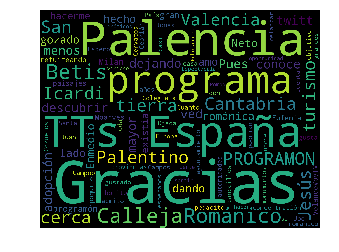

In [103]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords

# join tweets to a single string
words = text[55]

# remove URLs, RTs, and twitter handles
no_urls_no_tags = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                                and not word.startswith('#')
                            ])

wordcloud = WordCloud(
                      stopwords=stopwords.words('spanish'),
                      background_color='black',
                      width=1800,
                      height=1400
                     ).generate(no_urls_no_tags)

plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('./my_twitter_wordcloud_1.png', dpi=300)
plt.show()

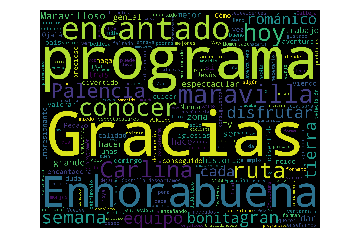

In [105]:
# join tweets to a single string
words = text[50]

# remove URLs, RTs, and twitter handles
no_urls_no_tags = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                                and not word.startswith('#')
                            ])

wordcloud = WordCloud(
                      stopwords=stopwords.words('spanish'),
                      background_color='black',
                      width=1800,
                      height=1400
                     ).generate(no_urls_no_tags)

plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('./my_twitter_wordcloud_2.png', dpi=300)
plt.show()

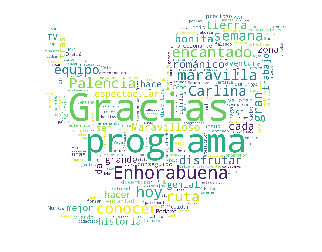

In [106]:
from scipy.misc import imread

twitter_mask = imread('./twitter_mask.png', flatten=True)


wordcloud = WordCloud(
                      stopwords=stopwords.words('spanish'),
                      background_color='white',
                      width=1800,
                      height=1400,
                      mask=twitter_mask
            ).generate(no_urls_no_tags)

plt.imshow(wordcloud)
plt.axis("off")
plt.savefig('./my_twitter_wordcloud_4.png', dpi=300)
plt.show()